<img style="float: left;" src="http://third.datacastle.cn/pkbigdata/master.other.img/8ef429f9-2032-47b8-bcc4-818fa9e41a25.png" width="50%">

code1 0.903837338746644
code2 0.9835963591120425
acc_id1 0.5338222775194814
device_code3 0.7796804400497676
acc_id2 0.7916966799816646
acc_id3 0.7919913561652806
market_code 0.7337109554056709

In [1]:
import numpy as np
import pandas as pd
import time,os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
data_path = '../data/'
op_train_sorted_file = 'op_train_sorted.csv' 
tran_train_sorted_file = 'tran_train_sorted.csv' 
tag_train_sorted_file = 'tag_train_sorted.csv' 

In [3]:
is_preprocessed = False
if not os.path.exists(data_path + op_train_sorted_file) or not os.path.exists(data_path + tran_train_sorted_file) or not os.path.exists(data_path + tag_train_sorted_file):
    print('[info]:start read from new train data...')
    is_preprocessed = False
    print('[info]:start read from op_train...')
    op_train = pd.read_csv('../data/operation_train_new.csv')
    print('[info]:start read from tran_train...')
    tran_train = pd.read_csv('../data/transaction_train_new.csv')
    print('[info]:start read from tag_train...')
    tag_train = pd.read_csv('../data/tag_train_new.csv')
else:
    print('[info]:start read from sorted data...')
    is_preprocessed = True
    print('[info]:start read from op_train...')
    op_train = pd.read_csv('../data/op_train_sorted.csv').drop('Unnamed: 0', axis=1)
    print('[info]:start read from tran_train...')
    tran_train = pd.read_csv('../data/tran_train_sorted.csv').drop('Unnamed: 0', axis=1)
    print('[info]:start read from tag_train...')
    tag_train = pd.read_csv('../data/tag_train_sorted.csv').drop('Unnamed: 0', axis=1)

[info]:start read from sorted data...
[info]:start read from op_train...
[info]:start read from tran_train...
[info]:start read from tag_train...


/home/alexliu/software/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1.数据预处理

In [4]:
def find_different_uid(op_uids, tran_uids):
    op_diff_uids = []
    for uid in op_uids:
        if uid not in tran_uids:
            op_diff_uids.append(uid)
        else:
            tran_uids.remove(uid)
    return op_diff_uids, tran_uids

def find_same_uid(src1_uids, src2_uids):
    same_uids = [uid for uid in src1_uids if uid in src2_uids]
    return same_uids

In [5]:
if not is_preprocessed:
    # 处理时间字符串
    op_train['time'] = op_train['day'].apply(lambda x: "2018-08-%02d" % x) + ' ' + op_train['time']
    op_train['timestamp'] = op_train['time'].apply(lambda x:time.mktime(time.strptime(x,'%Y-%m-%d %H:%M:%S')))

    tran_train['time'] = tran_train['day'].apply(lambda x: "2018-08-%02d" % x) + ' ' + tran_train['time']
    tran_train['timestamp'] = tran_train['time'].apply(lambda x:time.mktime(time.strptime(x,'%Y-%m-%d %H:%M:%S')))
    
    # 根据UID进行排序 再根据timestamp进行排序 
    op_train = op_train.sort_values(by=['UID', 'timestamp'],ascending=True).reset_index(drop=True)
    tran_train = tran_train.sort_values(by=['UID', 'timestamp'],ascending=True).reset_index(drop=True)
    tag_train = tag_train.sort_values(by=['UID'], ascending=True).reset_index(drop=True)

    op_train.to_csv(data_path + op_train_sorted_file)
    tran_train.to_csv(data_path + tran_train_sorted_file)
    tag_train.to_csv(data_path + tag_train_sorted_file)

In [6]:
# 去重
op_train_drop = op_train.drop_duplicates(inplace=True)
tran_train_drop = tran_train.drop_duplicates(inplace=True)
# 分组
op_train_gb = op_train.groupby('UID', as_index=False)
tran_train_gb = tran_train.groupby('UID', as_index=False)
#  获取op和tran各自的uid
op_train_uids = [uid for uid, item in op_train_gb.groups.items()]
tran_train_uids = [uid for uid, item in tran_train_gb.groups.items()]
# 获取op和tran各自的tag
op_tag = tag_train[tag_train['UID'].isin(op_train['UID'])]
tran_tag = tag_train[tag_train['UID'].isin(tran_train['UID'])]

#### 1.1处理缺失值

In [7]:
# op需要进行LabelEncoder的特征
op_columns = list(op_train.columns)
op_le_obj_fts = ['mode', 'os', 'version',
                  'device1', 'device2', 'device_code1', 'device_code2', 'device_code3',
                  'mac1', 'mac2', 'ip1', 'ip2', 'wifi', 'geo_code', 'ip1_sub', 'ip2_sub']
op_numtype_fts = ['success']

tran_columns = list(tran_train.columns)
tran_le_obj_fts = ['amt_src1', 'merchant',
                   'code1', 'code2', 'trans_type1', 'acc_id1', 'device_code1',
                   'device_code2', 'device_code3', 'device1', 'device2', 'mac1', 'ip1', 
                   'amt_src2', 'acc_id2', 'acc_id3', 'geo_code', 'trans_type2',
                   'market_code', 'ip1_sub']
tran_numtype_fts = ['channel', 'trans_amt', 'trans_type2', 'market_type']

In [8]:
def get_nan_counts(gb_count, ft_columns):
    hasnans_features_cnts = []
    for ft in ft_columns:
        cnts = gb_count[ft].value_counts()
        value = cnts[cnts.index == 0].values
        if len(value):
            hasnans_features_cnts.append((cnts.name,value[0]))
    return hasnans_features_cnts
        
def find_invalid_feature(gb_count, ft_columns):
    invalid_features = []
    for ft in ft_columns:
        cnts = gb_count[ft].value_counts()
        # 寻找值为0的统计数
        value = cnts[cnts.index == 0].values
        if len(value):
            if value[0] / gb_count.shape[0] > 0.5:
                print(cnts.name, value[0] / gb_count.shape[0])
                invalid_features.append(cnts.name)
    return invalid_features

def remove_list_item(src_l, rm_l):
    assert type(src_l) is list
    assert type(rm_l) is list
    
    for i in rm_l:
        if i in src_l:
            src_l.remove(i)
    return src_l

def preprocess(train_data, train_columns, le_obj_fts, numtype_fts):
    print('[info]: start fill nans...')
    for ft in numtype_fts:
        train_data[ft].fillna(-1, inplace=True)
        train_gb = train_data.groupby('UID', as_index=False)

    # 填补缺失值
    train_data = train_gb.ffill()
    train_gb = train_data.groupby('UID', as_index=False)
    train_data = train_gb.bfill()
    train_gb = train_data.groupby('UID', as_index=False)

    # 在填补基础上计数，去除nan值占一半以上的值
    print('[info]: start remove invalid features...')
    invalid_features = find_invalid_feature(train_gb.count(), train_columns)
    train_columns = remove_list_item(train_columns, invalid_features)
    le_obj_fts = remove_list_item(le_obj_fts, invalid_features)
    train_data.drop(invalid_features, axis='columns', inplace=True)

    # 填补剩余的缺失值
    print('[info]: start handle left nans...')
    op_hasnans_features_cnts = get_nan_counts(train_gb.count(), train_columns)
    for ft_cnts in op_hasnans_features_cnts:
        if train_data[ft_cnts[0]].hasnans:
            train_data[ft_cnts[0]].fillna('-1', inplace=True)
    train_gb = train_data.groupby('UID', as_index=False)
    print('[info]: handle nans finished.')

    # 对非数值型标签进行编码
    print('[info]: start label encoding...')
    le = LabelEncoder()
    for feature in le_obj_fts:
        try:
            print('[info]: %r label encoding...' %feature)
            train_data[feature] = le.fit_transform(train_data[feature])
        except TypeError as e:
            print(e)
    train_gb = train_data.groupby('UID', as_index=False)
    print('[info]: label encoding finished.')
    return train_data, train_gb, train_columns, le_obj_fts

def get_tag(uid):
    return tag_train[tag_train['UID'] == uid]

def get_op(uid):
    return op_train[op_train['UID'] == uid]

def get_tran(uid):
    return tran_train[tran_train['UID'] == uid]

def get_value_counts(uid, train_data):
    assert type(train_data) is pd.DataFrame
    for c in list(train_data.columns):
        print('[%r]'%c)
        print(train_data[train_data['UID']==uid][c].value_counts())
        print('====')

In [ ]:
op_train, op_train_gb, op_columns, op_le_obj_fts = preprocess(op_train, op_columns, op_le_obj_fts, op_numtype_fts)
#### tran的mac1探索

In [ ]:
for feature in op_le_obj_fts:
    try:
        print('[info]: %r value 0 replaced by -1 ...' %feature)
        op_train[feature].replace(0, -1, inplace=True)
    except TypeError as e:
        print(e)
op_train_gb = op_train.groupby('UID', as_index=False)

In [9]:
# 将op数据中的作假者与正常人分离开
op_train_fake_gp = op_train[op_train['UID'].isin(op_tag['UID'][op_tag['Tag'] == 1])].groupby('UID', as_index=False)
op_train_normal_gp = op_train[op_train['UID'].isin(op_tag['UID'][op_tag['Tag'] == 0])].groupby('UID', as_index=False)

In [9]:
op_discv_fts = ['os', 'version', 'device1', 'device2', 'device_code1', 'device_code2', 'device_code3', 'mac1']
tran_discv_fts = ['code1', 'code2', 'trans_type1', 'acc_id1', 'device_code1',
                   'device_code2', 'device_code3', 'device1', 'device2', 'mac1', 'ip1', 
                   'amt_src2', 'acc_id2', 'acc_id3', 'geo_code', 'trans_type2']

#### 典型羊毛党的特征

<img style="float: left;" src="http://third.datacastle.cn/pkbigdata/master.other.img/8ef429f9-2032-47b8-bcc4-818fa9e41a25.png" width="50%">

### op

|字段名|解释|构造特征思路|
|-|-|-|
|day|操作日期|day_cnts，求day的总数|
|||max_appear_day，操作次数最多的day|
|mode|操作类型|op_times_per2min，每2分钟的操作次数|
| ||op_topcnts_oneday， 单天中操作的次数|
| ||mode_max，同一操作类型的最大次数| 
| ||mode_rank1，排名第一的操作类型| 
|success|操作状态|suc_rate,成功率|
|device_code1|安卓操作设备唯一标识1|dev_code_frq可以与code2、code3合并，统一为device_code，但是无法区分设备与电脑，可以考虑将电脑ip作为设备号添加进来，以减少Nan值，设备更换的频次 = 设备更换的次数/天数|
|device_code2|安卓操作设备唯一标识2||
|device_code3|苹果操作设备唯一标识1||
|ip1|操作设备的ip地址|ip_diff_oneday_max,可以与ip2合并，统计一天中的变化的最大次数|
|||ip_diff_cnt,可以与ip2合并，统计所有统计中的变化次数|
|ip2|操作电脑的ip地址||
|ip1_sub|操作设备的ip的前三位地址|ipsub_in_diffUID可以与ip2_sub合并，ip_sub出现在不同UID的次数|
|ip2_sub|操作电脑的ip的前三位地址||
|mac1|操作设备的mac地址|mac1_in_diffUID, mac1出现在不同UID的次数|
|device1|操作设备的名称|dev_name_frq, 将非nan的ip2_sub合入至该列，统计不同设备名称的频次 = 操作设备的名称变化总次数/总的操作次数|
|device2|操作设备的类型|dev_type_frq, 将非nan的ip2_sub合入至该列，统计不同设备名称的频次 = 操作设备的名称变化总次数/总的操作次数|
|mac2|wifi的mac地址|useless|
|geo_code|经纬度|useless|
|wifi|wifi名称|useless|
|os|操作系统|useless|
|version|软件版本|useless|

### tran

|字段名|解释|构造特征思路|
|-|-|-|
|channel|操作平台|channel_frq，出现次数最多的channel的频次|
|||channel_max，出现次数最多的channel|
|day|操作日期|day_cnts，求day的总数|
|||day_appear_top，操作次数最多的day|
|trans_amt|交易金额|amt_frq，出现次数最多的金额的频次|
|||amt_appear_top，出现次数最多的交易金额|
|||tran_topcnts_oneday， 单天中交易的最多次数|
|amt_src1|资金类型|amt_src1_frq,成功率|
|device_code1|安卓操作设备唯一标识1|dev_code_frq可以与code2、code3合并，统一为device_code，但是无法区分设备与电脑，可以考虑将电脑ip作为设备号添加进来，以减少Nan值，设备更换的频次 = 设备更换的次数/天数|
|device_code2|安卓操作设备唯一标识2||
|device_code3|苹果操作设备唯一标识1||
|ip1|操作设备的ip地址|ip_diff_oneday_max,可以与ip2合并，统计一天中的变化的最大次数|
|||ip_diff_cnt,可以与ip2合并，统计所有统计中的变化次数|
|ip2|操作电脑的ip地址||
|ip1_sub|操作设备的ip的前三位地址|ipsub_in_diffUID可以与ip2_sub合并，ip_sub出现在不同UID的次数|
|ip2_sub|操作电脑的ip的前三位地址||
|mac1|操作设备的mac地址|mac1_in_diffUID, mac1出现在不同UID的次数|
|device1|操作设备的名称|dev_name_frq, 将非nan的ip2_sub合入至该列，统计不同设备名称的频次 = 操作设备的名称变化总次数/总的操作次数|
|device2|操作设备的类型|dev_type_frq, 将非nan的ip2_sub合入至该列，统计不同设备名称的频次 = 操作设备的名称变化总次数/总的操作次数|
|mac2|wifi的mac地址|useless|
|geo_code|经纬度|useless|
|wifi|wifi名称|useless|
|os|操作系统|useless|
|version|软件版本|useless|

In [15]:
op_train['ip_sub'] = op_train['ip1_sub'].replace(np.nan, '') + op_train['ip2_sub'].replace(np.nan, '')

In [53]:
get_tran(17520).T

,88429,88430,88431,88432,88433,88434,88435,88436,88437,88438,...,92449,92450,92451,92452,92453,92454,92455,92456,92457,92458
UID,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,...,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520
channel,102,102,102,102,102,102,102,102,140,140,...,140,140,140,140,140,140,140,140,140,102
day,2,2,4,4,4,5,5,9,9,9,...,29,29,29,29,29,29,29,29,29,30
time,2018-08-02 15:00:03,2018-08-02 15:01:17,2018-08-04 11:54:21,2018-08-04 11:54:21,2018-08-04 11:54:21,2018-08-05 08:59:10,2018-08-05 08:59:10,2018-08-09 10:28:10,2018-08-09 10:38:38,2018-08-09 10:38:38,...,2018-08-29 16:06:36,2018-08-29 16:06:58,2018-08-29 16:07:09,2018-08-29 16:07:25,2018-08-29 16:07:38,2018-08-29 16:07:57,2018-08-29 16:08:08,2018-08-29 16:08:36,2018-08-29 16:09:10,2018-08-30 03:12:05
trans_amt,27282,37612,749,53815,2818,339,27043,13691,2818,1730,...,102,102,105,105,105,105,105,108,105,80759
amt_src1,155c9e1c32bd0fa2,155c9e1c32bd0fa2,155c9e1c32bd0fa2,155c9e1c32bd0fa2,acdbdb842ac20f1e,155c9e1c32bd0fa2,155c9e1c32bd0fa2,155c9e1c32bd0fa2,f29829bc82459191,c5fc631370cabc0d,...,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,4d7831c6f695ab19,9451ef3c5a0d6807
merchant,3bd5cf7c40962299,3bd5cf7c40962299,d8babe2d19fa0c08,d8babe2d19fa0c08,d8babe2d19fa0c08,d8babe2d19fa0c08,d8babe2d19fa0c08,3bd5cf7c40962299,e7c8d6677b135c86,e7c8d6677b135c86,...,f916ed75731030c7,d851acb4c7635b2a,d851acb4c7635b2a,d851acb4c7635b2a,d851acb4c7635b2a,d851acb4c7635b2a,d851acb4c7635b2a,d851acb4c7635b2a,d851acb4c7635b2a,8094cb789741f0f1
code1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
code2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trans_type1,61bfb66c928f36ac,9d7dd7b80e806024,6d55c54c8b1056fb,6d55c54c8b1056fb,26bcf43a19df14c8,6d55c54c8b1056fb,6d55c54c8b1056fb,61bfb66c928f36ac,c2f2023d279665b2,c2f2023d279665b2,...,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,c2f2023d279665b2,6d55c54c8b1056fb


In [52]:
get_value_counts(17520, tran_train)

['UID']
17520    4030
Name: UID, dtype: int64
====
['channel']
140    3017
102    1013
Name: channel, dtype: int64
====
['day']
25    2909
26    1001
29      96
9        7
27       5
14       3
4        3
5        2
2        2
30       1
16       1
Name: day, dtype: int64
====
['time']
2018-08-14 21:02:28    3
2018-08-04 11:54:21    3
2018-08-09 10:38:38    2
2018-08-05 08:59:10    2
2018-08-09 10:39:03    2
2018-08-25 11:15:54    2
2018-08-25 19:35:39    1
2018-08-26 22:18:49    1
2018-08-26 22:46:36    1
2018-08-26 19:11:37    1
2018-08-25 21:15:40    1
2018-08-26 23:07:01    1
2018-08-26 19:14:26    1
2018-08-26 23:36:13    1
2018-08-25 10:10:02    1
2018-08-25 21:20:39    1
2018-08-25 18:39:50    1
2018-08-25 11:01:38    1
2018-08-26 19:37:02    1
2018-08-25 19:16:20    1
2018-08-25 19:58:51    1
2018-08-26 21:57:16    1
2018-08-26 19:21:39    1
2018-08-25 18:44:06    1
2018-08-25 20:28:39    1
2018-08-25 19:37:58    1
2018-08-26 22:17:10    1
2018-08-25 10:40:19    1
2018-08-26 21

In [26]:
get_op(10000).T

,0,3,4,7,8
UID,10000,10000,10000,10000,10000
day,13,13,26,26,26
mode,c8741ce15ceac2a4,270ca3ca8f0d1126,c8741ce15ceac2a4,d25caee90b27fa9b,d25caee90b27fa9b
success,1,1,1,1,1
time,2018-08-13 14:20:56,2018-08-13 14:22:59,2018-08-26 12:23:48,2018-08-26 12:24:01,2018-08-26 12:24:21
os,103,103,103,103,103
version,7.0.5,7.0.5,7.0.7,7.0.7,7.0.7
device1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1
device2,IPHONE 5,IPHONE 5,IPHONE 5,NaN,NaN
device_code1,NaN,NaN,NaN,NaN,NaN


In [29]:
get_value_counts(10001,op_train)

['UID']
10001    65
Name: UID, dtype: int64
====
['day']
3     14
11    12
2     11
7      8
13     7
4      5
12     4
5      4
Name: day, dtype: int64
====
['mode']
c8741ce15ceac2a4    34
79f8b86938180c3c    15
d25caee90b27fa9b     9
b501fa4fc58206b9     4
1c341176507fbd9b     2
963bd8a75ff9ab37     1
Name: mode, dtype: int64
====
['success']
1.0    49
0.0     1
Name: success, dtype: int64
====
['time']
2018-08-03 07:11:07    2
2018-08-03 07:04:02    2
2018-08-02 18:11:19    2
2018-08-03 07:23:09    2
2018-08-03 07:18:16    2
2018-08-03 07:20:09    2
2018-08-12 12:38:06    2
2018-08-05 12:31:36    2
2018-08-03 07:03:58    2
2018-08-11 07:01:50    2
2018-08-02 08:30:52    1
2018-08-07 16:12:52    1
2018-08-03 07:18:05    1
2018-08-02 08:31:24    1
2018-08-04 22:28:08    1
2018-08-11 07:02:20    1
2018-08-12 12:38:22    1
2018-08-13 15:03:56    1
2018-08-13 15:03:57    1
2018-08-13 15:04:09    1
2018-08-13 15:02:59    1
2018-08-04 22:28:16    1
2018-08-11 07:02:09    1
2018-08-11 06:56

In [23]:
get_op(17520).T.loc[:, str(240357):str(240357+30)]

,240357,240360,240362,240364,240366,240367,240368,240370,240371,240374,240376,240378,240379,240380,240381,240382,240386
UID,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520
day,4,4,4,5,5,6,6,6,7,8,8,8,9,9,9,12,12
mode,c8741ce15ceac2a4,e1d2fad8ffdc66b3,d25caee90b27fa9b,c8741ce15ceac2a4,d25caee90b27fa9b,c8741ce15ceac2a4,c8741ce15ceac2a4,cca82161b59127c1,c8741ce15ceac2a4,c8741ce15ceac2a4,c8741ce15ceac2a4,c8741ce15ceac2a4,c8741ce15ceac2a4,d25caee90b27fa9b,d25caee90b27fa9b,c8741ce15ceac2a4,2f3e878175e34d9c
success,1,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
time,2018-08-04 11:52:59,2018-08-04 11:53:14,2018-08-04 11:54:21,2018-08-05 08:58:45,2018-08-05 08:59:09,2018-08-06 21:29:06,2018-08-06 21:29:07,2018-08-06 21:30:04,2018-08-07 14:54:12,2018-08-08 08:52:19,2018-08-08 15:13:29,2018-08-08 19:15:03,2018-08-09 10:32:01,2018-08-09 10:38:42,2018-08-09 10:39:07,2018-08-12 19:13:01,2018-08-12 19:13:07
os,103,200,103,103,103,103,103,200,103,103,103,103,103,103,103,103,103
version,7.0.5,NaN,7.0.5,7.0.5,7.0.5,7.0.5,7.0.5,NaN,7.0.5,7.0.5,7.0.5,7.0.5,7.0.5,7.0.5,7.0.5,7.0.7,7.0.7
device1,aca4977fbe8741e1,NaN,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,NaN,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1
device2,IPHONE 8 PLUS,NaN,NaN,IPHONE 8 PLUS,IPHONE,IPHONE 8 PLUS,IPHONE 8 PLUS,NaN,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE,IPHONE,IPHONE 8 PLUS,IPHONE 8 PLUS
device_code1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
get_op(17520).T.loc[:, str(240357+30):str(240357+63)]

,240388,240389,240390,240391,240392,240393,240395,240396,240397,240399,...,240411,240412,240413,240414,240415,240416,240417,240418,240419,240420
UID,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520,...,17520,17520,17520,17520,17520,17520,17520,17520,17520,17520
day,15,15,15,15,15,16,16,16,25,25,...,29,29,29,29,29,29,29,29,29,29
mode,c8741ce15ceac2a4,b501fa4fc58206b9,963bd8a75ff9ab37,b501fa4fc58206b9,d25caee90b27fa9b,c8741ce15ceac2a4,d25caee90b27fa9b,c8741ce15ceac2a4,c8741ce15ceac2a4,c8741ce15ceac2a4,...,acfaded7e04e7ba0,c8741ce15ceac2a4,c8741ce15ceac2a4,d25caee90b27fa9b,d25caee90b27fa9b,d25caee90b27fa9b,d25caee90b27fa9b,d25caee90b27fa9b,d25caee90b27fa9b,d25caee90b27fa9b
success,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
time,2018-08-15 11:07:07,2018-08-15 11:07:22,2018-08-15 11:07:42,2018-08-15 11:07:45,2018-08-15 11:07:45,2018-08-16 10:43:42,2018-08-16 10:43:58,2018-08-16 20:37:17,2018-08-25 09:41:53,2018-08-25 22:18:45,...,2018-08-29 15:25:09,2018-08-29 15:27:08,2018-08-29 15:27:17,2018-08-29 15:28:15,2018-08-29 15:37:08,2018-08-29 15:37:31,2018-08-29 15:37:43,2018-08-29 15:37:54,2018-08-29 15:38:21,2018-08-29 15:38:38
os,103,103,103,103,103,103,103,103,103,103,...,102,102,102,102,103,103,103,103,103,103
version,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,...,7.0.9,7.0.9,7.0.9,7.0.9,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7,7.0.7
device1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,...,09baf2f39bc3dc86,09baf2f39bc3dc86,09baf2f39bc3dc86,09baf2f39bc3dc86,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1,aca4977fbe8741e1
device2,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE,IPHONE 8 PLUS,IPHONE,IPHONE 8 PLUS,IPHONE 8 PLUS,IPHONE 8 PLUS,...,EVA-AL00,EVA-AL00,EVA-AL00,NaN,NaN,IPHONE,IPHONE,IPHONE,IPHONE,IPHONE
device_code1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,fed11c13d8ef819d,fed11c13d8ef819d,fed11c13d8ef819d,fed11c13d8ef819d,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
get_value_counts(17520, op_train)

['UID']
17520    63
Name: UID, dtype: int64
====
['day']
29    31
15     5
26     4
16     3
9      3
8      3
6      3
4      3
25     2
12     2
5      2
30     1
7      1
Name: day, dtype: int64
====
['mode']
d25caee90b27fa9b    32
c8741ce15ceac2a4    23
b501fa4fc58206b9     2
cca82161b59127c1     1
acfaded7e04e7ba0     1
072eee5c88d380df     1
2f3e878175e34d9c     1
963bd8a75ff9ab37     1
e1d2fad8ffdc66b3     1
Name: mode, dtype: int64
====
['success']
1.0    60
0.0     2
Name: success, dtype: int64
====
['time']
2018-08-29 15:25:09    2
2018-08-15 11:07:45    2
2018-08-29 16:01:49    1
2018-08-29 16:07:27    1
2018-08-29 15:41:46    1
2018-08-09 10:32:01    1
2018-08-05 08:59:09    1
2018-08-29 16:04:23    1
2018-08-09 10:38:42    1
2018-08-26 18:54:10    1
2018-08-15 11:07:07    1
2018-08-15 11:07:22    1
2018-08-08 15:13:29    1
2018-08-16 20:37:17    1
2018-08-29 15:37:08    1
2018-08-29 15:37:43    1
2018-08-29 15:59:35    1
2018-08-12 19:13:01    1
2018-08-29 15:27:08    1
20

In [10]:
get_value_counts(10000, op_train)

['UID']
10000    5
Name: UID, dtype: int64
====
['day']
26    3
13    2
Name: day, dtype: int64
====
['mode']
d25caee90b27fa9b    2
c8741ce15ceac2a4    2
270ca3ca8f0d1126    1
Name: mode, dtype: int64
====
['success']
1.0    5
Name: success, dtype: int64
====
['time']
2018-08-13 14:22:59    1
2018-08-13 14:20:56    1
2018-08-26 12:24:01    1
2018-08-26 12:24:21    1
2018-08-26 12:23:48    1
Name: time, dtype: int64
====
['os']
103    5
Name: os, dtype: int64
====
['version']
7.0.7    3
7.0.5    2
Name: version, dtype: int64
====
['device1']
aca4977fbe8741e1    5
Name: device1, dtype: int64
====
['device2']
IPHONE 5    3
Name: device2, dtype: int64
====
['device_code1']
Series([], Name: device_code1, dtype: int64)
====
['device_code2']
Series([], Name: device_code2, dtype: int64)
====
['device_code3']
deb68f7028682008    5
Name: device_code3, dtype: int64
====
['mac1']
Series([], Name: mac1, dtype: int64)
====
['mac2']
Series([], Name: mac2, dtype: int64)
====
['ip1']
34c715882de1a508  

In [43]:
op_tag = pd.merge(op_train, tag_train, on='UID', how='left').replace(0, np.nan)
op_tag = op_tag.groupby('UID').count().drop(op_le_obj_fts, axis=1).drop(['success', 'time', 'timestamp'], axis=1)
op_tag = op_tag.reset_index()
op_tag['Tag'] = op_tag['Tag']/op_tag['day']
op_tag.drop('day',axis=1, inplace=True)
mode_max = []
mode_std = []
mode_rank1 = []
mode_count = []
for uid in list(op_train_gb.indices.keys()):
    uid_mode = op_train_gb.get_group(uid)['mode']
    mode_std.append(uid_mode.value_counts().std())    
    mode_max.append(uid_mode.value_counts().values[0])    
    mode_rank1.append(uid_mode.value_counts().index[0])
    mode_count.append(uid_mode.count())
op_tag['mode_max_rate'] = np.array(mode_max)/np.array(mode_count)*np.array(mode_std)
op_tag['mode_rank1'] = np.array(mode_rank1)

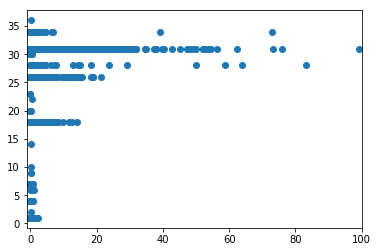

In [72]:
# 查看排第一的操作类型个数和排名第一的操作类型的关系
le = LabelEncoder()
op_tag['mode_rank1'] = le.fit_transform(op_tag['mode_rank1'])
op_tag_fake = op_tag[op_tag['Tag'] == 0]
op_tag_normal = op_tag[op_tag['Tag'] == 1]
plt.xlim(-1,100)
plt.scatter(op_tag_normal['mode_max_rate'],op_tag_normal['mode_rank1'])

/home/alexliu-ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


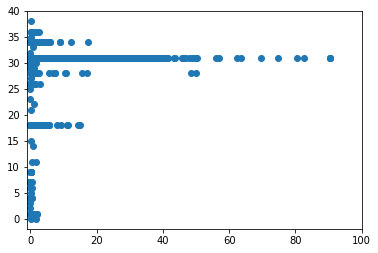

In [71]:
new_fake_index = np.random.choice(op_tag_fake.index, size=op_tag_normal.shape[0])
new_fake_index
plt.xlim(-1,100)
op_part_fake = op_tag_fake.ix[pd.Index(new_fake_index)]
plt.scatter(op_part_fake['mode_max_rate'], op_part_fake['mode_rank1'])

In [22]:
op_tag1 = op_tag[op_tag['Tag'] == 1]
op_tag0 = op_tag[op_tag['Tag'] == 0]
# op_tag_tag1_sorted = op_tag1['mode_std'].value_counts().sort_index(ascending=False)
# op_tag_tag0_sorted = op_tag0['mode_std'].value_counts().sort_index(ascending=False)

op_tag_tag1_sorted = op_tag1['mode_max'].value_counts().sort_index(ascending=False)
op_tag_tag0_sorted = op_tag0['mode_max'].value_counts().sort_index(ascending=False)

print('tag1:',op_tag_tag1_sorted[op_tag_tag1_sorted.index>50].count())
print('tag0:',op_tag_tag0_sorted[op_tag_tag0_sorted.index>50].count())

tag1: 82
tag0: 273


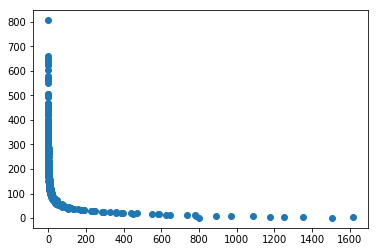

In [23]:
x = op_tag_tag0_sorted.values
y = op_tag_tag0_sorted.index
plt.scatter(x, y)

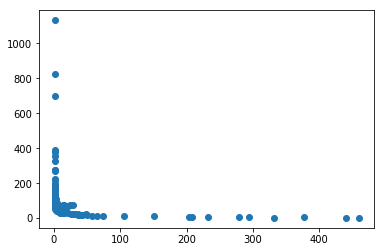

In [24]:
x = op_tag_tag1_sorted.values
y = op_tag_tag1_sorted.index
plt.scatter(x, y)

In [ ]:
op_tag_tag1_sorted.shape

In [ ]:
op_tag_tag0_sorted.shape

In [ ]:
op_tag_gb_sorted_tag0

In [ ]:
op_train_gb.get_group(17520)['mode'].value_counts().std()

In [ ]:
op_train[op_train['UID']==17520]['mode'].value_counts().std()

#### tran的mac1探索

In [ ]:
tran_train[tran_train['UID']==10001]

In [ ]:
t_mac1_gb = tran_tag.loc[:,['mac1', 'Tag']].groupby('mac1')

In [ ]:
t_mac1_des = t_mac1_gb.describe()

In [ ]:
get_tag(10001)

In [ ]:
get_tran(54035)

In [ ]:
tran_tag[tran_tag['mac1'].isin(t_mac1_des['Tag'][t_mac1_des['Tag']['std']>0].index)]['UID'].count()

In [ ]:
t_mac1_des['Tag'][t_mac1_des['Tag']['std']>0].index

In [ ]:
t_mac1_gb['UID']

In [ ]:
print(t_mac1_gb['Tag'])

In [ ]:
for fk in fake_keys:
    print(op_train_fake_gp.get_group(fk)['mac1'].value_counts())

In [ ]:
tran_tag = pd.merge(tran_train, tag_train, on='UID', how='left')

In [ ]:
tran_tag

In [ ]:
tran_train_fake.count()

In [ ]:
tran_train_normal.count()

In [ ]:
fake_keys=[]
for key, item in op_train_fake_gp.indices.items():
    fake_keys.append(key)
    
normal_keys=[]
for key, item in op_train_normal_gp.indices.items():
    normal_keys.append(key)

In [ ]:
type(op_train_fake_gp.get_group(10000))
df_10000 = op_train_fake_gp.get_group(10000)
df_10000['mode'].value_counts()

In [ ]:
op_train['mode'].value_counts(dropna=False)

In [ ]:
fake_keys=[]
for key, item in op_train_fake_gp.indices.items():
    fake_keys.append(key)

#### 1.2 tran处理

In [ ]:
# tran需要进行LabelEncoder的特征
tran_columns = ['UID', 'channel', 'day', 'time', 'trans_amt', 'amt_src1', 'merchant',
       'code1', 'code2', 'trans_type1', 'acc_id1', 'device_code1',
       'device_code2', 'device_code3', 'device1', 'device2', 'mac1', 'ip1',
       'bal', 'amt_src2', 'acc_id2', 'acc_id3', 'geo_code', 'trans_type2',
       'market_code', 'market_type', 'ip1_sub', 'timestamp']
tran_operator_features = []
tran_user_features = []